In [1]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models import vanilla_autoencoder


import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go



%load_ext tensorboard
!rm -rf ../workfiles/logs/

Retaining patients that are included in phases 1 & 2
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 23 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
selecting genes based on median absolute deviation threshold:  5 ...
0.0
6486.5996


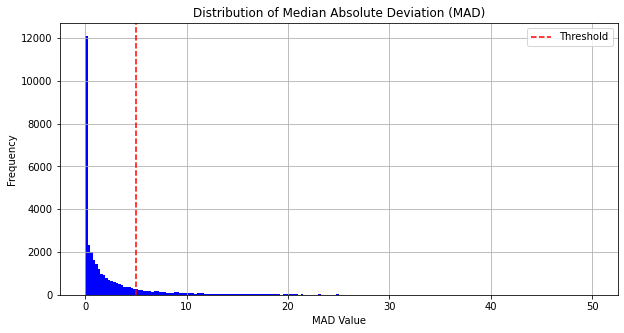

removing 28744 genes under the MAD threshold from the dataset
number of genes selected :  5527
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 23
keeping sample as is, no conversion to time series


In [2]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 5, 
    subsample= 100,
    retain_phases="Both", 
    normalization = False,
    as_time_series = False,
    log1p = True,
    MT_removal = True,
    min_max = True)

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  1 ...
0.0
4194.0


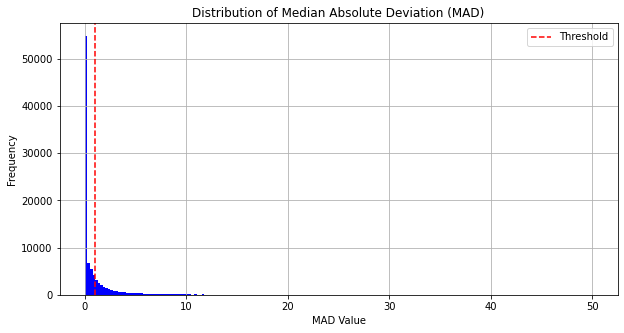

removing 71320 genes under the MAD threshold from the dataset
number of genes selected :  23989
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [25]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 1, 
    subsample=None,
    retain_phases = None,
    normalization = False,
    minimum_time_point = "BL",
    as_time_series = False,
    transpose = False,
    MT_removal = False,
    log1p = True,
    min_max = True)


loading samples...
loaded 2259 / 2259 samples
selecting genes based on median absolute deviation threshold:  2 ...
0.0
285733.0


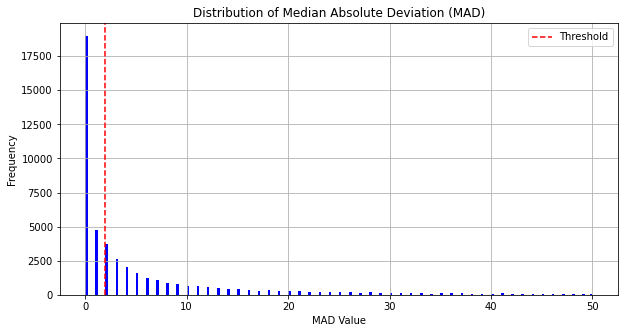

removing 39580 genes under the MAD threshold from the dataset
number of genes selected :  21080
number of genes selected :  21080
log(1 + x) transformation...
scaling to [0, 1]...
shape of the dataset : (2259, 21080)
number of seq in the dataset : 2259


In [59]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session


as_time_series = True
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_cancer(
    feature_selection_threshold = 2, 
    batch_size = 32, 
    normalization = False,
    MT_removal = False)

In [61]:
importlib.reload(vanilla_autoencoder) # to allow modification of the script without restarting the whole session

latent_dim = 64

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [62]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=30, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=70)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [63]:
hist = autoencoder.fit(x_train, epochs=200, callbacks=cb) # around 16 hours for transcripts dataset 

Epoch 1/200
71/71 [==============================] - 47s 641ms/step - loss: 0.3898 - lr: 0.0010
Epoch 2/200
71/71 [==============================] - 28s 401ms/step - loss: 0.0223 - lr: 0.0010
Epoch 3/200
71/71 [==============================] - 34s 480ms/step - loss: 0.0219 - lr: 0.0010
Epoch 4/200
71/71 [==============================] - 32s 455ms/step - loss: 0.0193 - lr: 0.0010
Epoch 5/200
71/71 [==============================] - 45s 629ms/step - loss: 0.0174 - lr: 0.0010
Epoch 6/200
71/71 [==============================] - 36s 511ms/step - loss: 0.0187 - lr: 0.0010
Epoch 7/200
71/71 [==============================] - 33s 472ms/step - loss: 0.0154 - lr: 0.0010
Epoch 8/200
71/71 [==============================] - 31s 440ms/step - loss: 0.0143 - lr: 0.0010
Epoch 9/200
71/71 [==============================] - 27s 382ms/step - loss: 0.0139 - lr: 0.0010
Epoch 10/200
71/71 [==============================] - 28s 392ms/step - loss: 0.0137 - lr: 0.0010
Epoch 11/200
71/71 [===================

Keeping in mind that outputting a constant solution for every observation yields a loss value of ~0.2 for MT removed, log1p transformed dataset.

benchmarking model : vanilla_autoencoder
number of parametters of the model: 44519040
shape of the dataset: (2259, 21080)
the dataset meets the min_max requirement
loss: 20198.643
this is the first entry to the benchmark history


,model_name,param_count,loss,obs_count,gene_number
0,vanilla_autoencoder,44519040,20198.642578,2259,21080


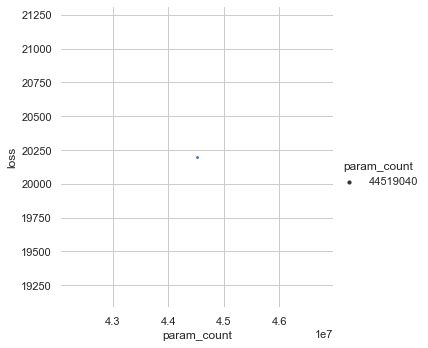

In [64]:
importlib.reload(benchmark) # to allow modification of the script without restarting the whole session
benchmark.benchmark(autoencoder, x_train)

In [65]:
autoencoder.load_weights(checkpoint_filepath)


[0.1406068205833435, 0.022268256172537804, 0.021556992083787918, 0.018089020624756813, 0.01987682841718197, 0.017544694244861603, 0.015001995489001274, 0.014114094898104668, 0.013636505231261253, 0.013507187366485596, 0.013006357476115227, 0.012850785627961159, 0.012603430077433586, 0.012524725869297981, 0.012376573868095875, 0.012449532747268677, 0.012355610728263855, 0.01204645074903965, 0.0120632853358984, 0.01166791282594204, 0.011476870626211166, 0.011424850672483444, 0.01146863866597414, 0.01231243647634983, 0.01303935144096613, 0.011382120661437511, 0.01123403012752533, 0.011173696257174015, 0.011222466826438904, 0.011409014463424683, 0.011346595361828804, 0.011183399707078934, 0.011169467121362686, 0.011322098784148693, 0.011395065113902092, 0.011200095526874065, 0.011193028651177883, 0.011111884377896786, 0.0110864182934165, 0.011022969149053097, 0.01116220559924841, 0.011245832778513432, 0.01120420265942812, 0.011458749882876873, 0.011088656261563301, 0.010915097780525684, 0.

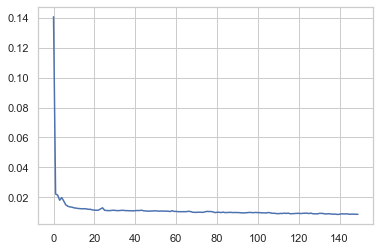

In [69]:
plt.plot(hist.history['loss'][:150])
print(hist.history['loss'])




### some diagnosis

In [70]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_single_obs_processing(x_train, autoencoder)

In [71]:
autoencoder.encoder.save('../workfiles/simple_ae')
autoencoder.decoder.save('../workfiles/decoder_simple_ae')


INFO:tensorflow:Assets written to: ../workfiles/simple_ae/assets


INFO:tensorflow:Assets written to: ../workfiles/simple_ae/assets


INFO:tensorflow:Assets written to: ../workfiles/decoder_simple_ae/assets


INFO:tensorflow:Assets written to: ../workfiles/decoder_simple_ae/assets


In [72]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

71/71 [==============================] - 1s 16ms/step


In [77]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [78]:
df.to_csv("../workfiles/FC_ae_"+x_train._name+".csv", index=False)


71/71 [==============================] - 1s 11ms/step


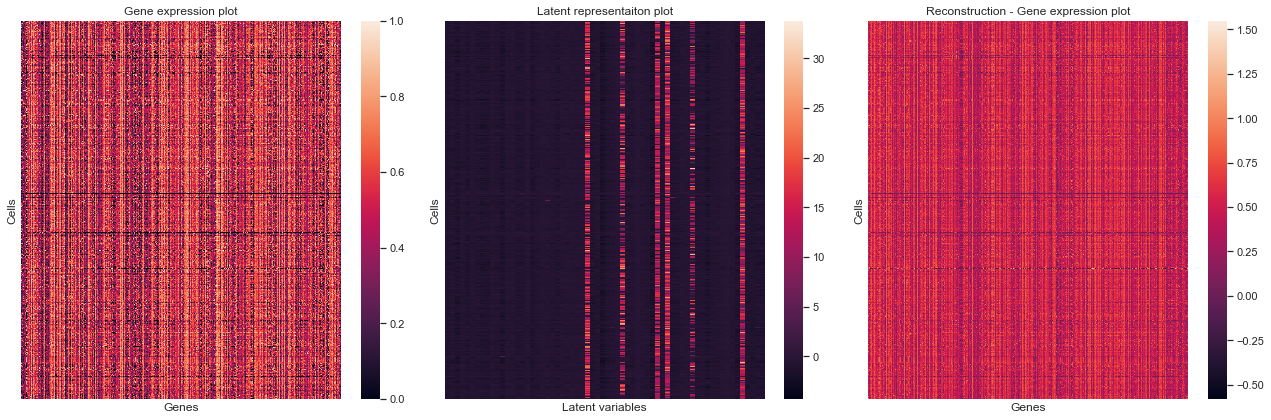

In [79]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_dataset_processing(x_train, autoencoder)